### Generating and evaluating models to be used in Autumncast web app

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
import pickle
from datetime import datetime
from datetime import date
import calendar
import rasterio
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

### Part 1: Linear Model

In [2]:
Edata = pd.read_csv('E_means_data.csv', index_col = [0])
Edata.head()

,Latitude,Longitude,Year,Common_Name,day_mean,counts,day_std,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10
0,39.747726,-77.569374,2014,red maple,302.000000,1,NaN,311.0,319.0,12.926172,8.762300,0.261172,27.435165,3.816279,1.814483,12.906835,10.276417
1,39.747726,-77.569374,2015,pin oak,320.928571,14,18.590586,290.0,324.0,15.002828,6.216567,3.820897,28.832998,1.799410,2.507759,12.906835,10.276417
2,39.747726,-77.569374,2015,red maple,306.875000,8,13.367738,290.0,324.0,15.002828,6.216567,3.820897,28.832998,1.799410,2.507759,12.906835,10.276417
3,39.747726,-77.569374,2019,red maple,289.000000,1,NaN,305.0,313.0,15.299345,9.031834,-0.548655,30.049755,3.498590,0.486034,12.906835,10.276417
4,39.758430,-77.507004,2015,Norway maple,293.333333,3,5.507571,290.0,312.0,14.061414,5.379034,3.343448,27.441246,2.503935,4.182069,12.907182,10.275751


Text(0.5, 1.0, 'Day length, Nov 1st')

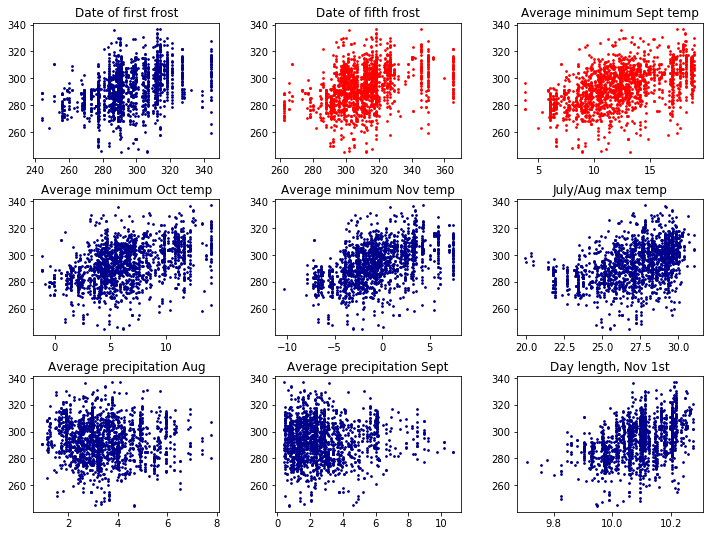

In [3]:
fig = plt.figure(figsize=(12,9))
fig.subplots_adjust(wspace = .3, hspace =.3)
ax = fig.add_subplot(331)
ax.scatter(Edata.var1, Edata.day_mean, color ='darkblue', s = 3)
ax.set_title('Date of first frost')
ax = fig.add_subplot(332)
ax.scatter(Edata.var2, Edata.day_mean, color ='red', s = 3)
ax.set_title('Date of fifth frost')
ax = fig.add_subplot(333)
ax.scatter(Edata.var3, Edata.day_mean, color ='red', s = 3)
ax.set_title('Average minimum Sept temp')
ax = fig.add_subplot(334)
ax.scatter(Edata.var4, Edata.day_mean, color ='darkblue', s = 3)
ax.set_title('Average minimum Oct temp')
ax = fig.add_subplot(335)
ax.scatter(Edata.var5, Edata.day_mean, color ='darkblue', s = 3)
ax.set_title('Average minimum Nov temp')
ax = fig.add_subplot(336)
ax.scatter(Edata.var6, Edata.day_mean, color ='darkblue', s = 3)
ax.set_title('July/Aug max temp')
ax = fig.add_subplot(337)
ax.scatter(Edata.var7, Edata.day_mean, color ='darkblue', s = 3)
ax.set_title('Average precipitation Aug')
ax = fig.add_subplot(338)
ax.scatter(Edata.var8, Edata.day_mean, color ='darkblue', s = 3)
ax.set_title('Average precipitation Sept')
ax = fig.add_subplot(339)
ax.scatter(Edata.var10, Edata.day_mean, color ='darkblue', s = 3)
ax.set_title('Day length, Nov 1st')


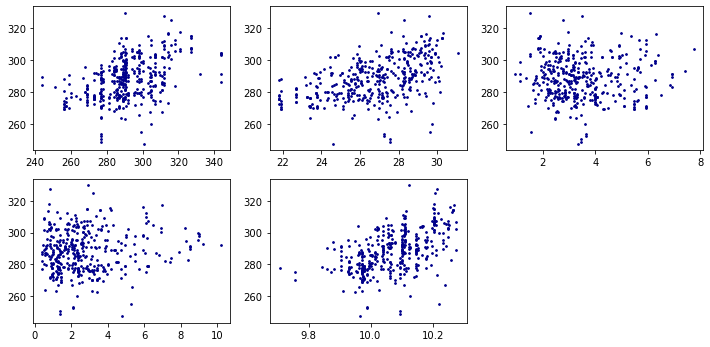

In [4]:
#make the same plots for only Red Maple
acer = Edata[Edata.Common_Name == 'red maple']
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(331)
ax.scatter(acer.var1, acer.day_mean, color ='darkblue', s = 3)
ax = fig.add_subplot(332)
ax.scatter(acer.var6, acer.day_mean, color ='darkblue', s = 3)
ax = fig.add_subplot(333)
ax.scatter(acer.var7, acer.day_mean, color ='darkblue', s = 3)
ax = fig.add_subplot(334)
ax.scatter(acer.var8, acer.day_mean, color ='darkblue', s = 3)
ax = fig.add_subplot(335)
ax.scatter(acer.var10, acer.day_mean, color ='darkblue', s = 3)

#'ppt_MAM','ppt_JF', 'Latitude', 'Longitude'
plt.show()
#'ppt_MAM','ppt_JF', 'Latitude', 'Longitude'
plt.show()

Mostly I'm interested in prediction, so use all of the features in the first model, then re-run with features that are less correlated

coefficient of determination:  0.3345671320930861
intercept:  450.9754491622908
slope:  [ -0.02702706  -0.20917806   0.98561532   0.59719975   1.01724378
   0.71781566  -1.32887219   0.08848163 -20.56307498  15.11370077]
mean average error:  9.088787657836106


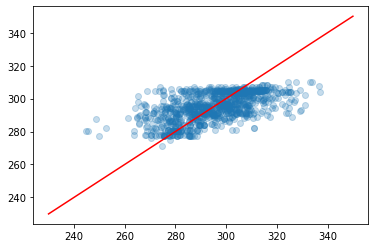

In [5]:
#first a simple linear model (not including species)
#keep only the locations/years/species with more than 5 observations (mean estimates of 'peak' should be more reliable)
better_sampled = Edata[(Edata.counts >= 5)] 
x_model = np.array(better_sampled[['var1','var2', 'var3', 'var4', 'var5', 'var6', 'var7', 'var8', 'var9', 'var10']])
y_model = np.array(better_sampled.day_mean)
model = LinearRegression().fit(x_model,y_model)
r_sq = model.score(x_model,y_model)
print('coefficient of determination: ', r_sq)
print('intercept: ', model.intercept_)
print('slope: ', model.coef_)
predictions = model.predict(x_model)

differences = abs(better_sampled.day_mean - predictions)
print('mean average error: ', differences.mean())

plt.scatter(better_sampled.day_mean,predictions, alpha = 0.25)

#plot the 1:1 line to see the model performance better
line = np.linspace(230,350,100)
plt.plot(line, line, '-r')
plt.show()

mean average error train data:  8.850285767188486
mean average error test data:  10.468684810665984


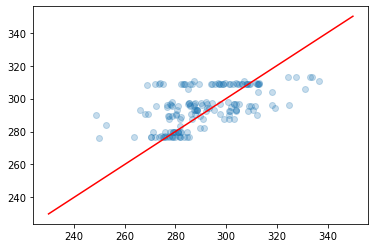

In [6]:
#Split the data into train/test datasest to evalutate:
train = Edata[(Edata.counts >= 5) & (Edata.Year <= 2018)]
test = Edata[(Edata.counts >= 5) & (Edata.Year == 2019)]

x_model = np.array(train[['var1','var2', 'var3', 'var4', 'var5', 'var6', 'var7', 'var8', 'var9', 'var10']])
y_model = np.array(train.day_mean)
model = LinearRegression().fit(x_model,y_model)
r_sq = model.score(x_model,y_model)

x_test = np.array(test[['var1','var2', 'var3', 'var4', 'var5', 'var6', 'var7', 'var8', 'var9', 'var10']])

predictions_train = model.predict(x_model)
predictions_test = model.predict(x_test)

differences = abs(y_model - predictions_train)
print('mean average error train data: ', differences.mean())

differences = abs(test.day_mean - predictions_test)
print('mean average error test data: ', differences.mean())

plt.scatter(test.day_mean,predictions_test, alpha = 0.25)

#plot the 1:1 line to see the model performance better
line = np.linspace(230,350,100)
plt.plot(line, line, '-r')
plt.show()

The first model was overfit -- probably too many features for the amount of data. Try removing some of the colinear features and re-run.

In [7]:
#Now look at which variables are correlated
#I removed one variable for each pair with pearson correlation coefficient >= 0.7
#I did this iteratively, removing one at a time until I got to this set:

check = Edata[['var1','var2', 'var3', 'var4', 'var5', 'var6', 'var7', 'var8', 'var9', 'var10']]
reduced = Edata[['var1','var6', 'var7', 'var8', 'var10']]

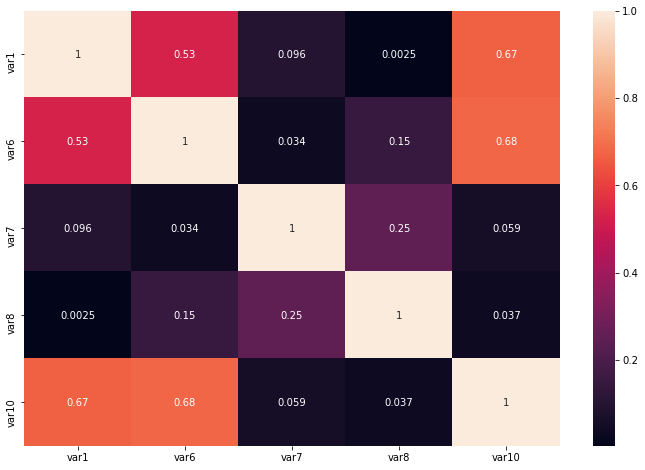

In [8]:
plt.figure(figsize=(12,8))
corr = reduced.corr(method = 'pearson')
ax = sns.heatmap(abs(corr), annot = True)


coefficient of determination:  0.2788424146250883
intercept:  -164.74940222392144
slope:  [ 1.17538339e-01  1.29486359e+00 -7.53086042e-01  1.43787295e-02
  3.87402259e+01]


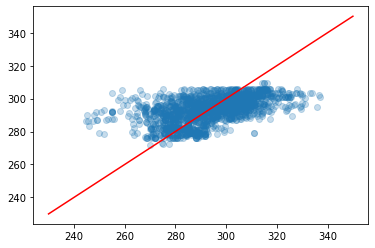

In [9]:
#run the model with only 5 climate/day length features
x_model = np.array(reduced)
y_model = np.array(Edata.day_mean)
model = LinearRegression().fit(x_model,y_model)
r_sq = model.score(x_model,y_model)
print('coefficient of determination: ', r_sq)
print('intercept: ', model.intercept_)
print('slope: ', model.coef_)
predictions = model.predict(x_model)
plt.scatter(Edata.day_mean,predictions, alpha = 0.25)

x = np.linspace(230,350,100)
plt.plot(x, x, '-r')

coefficient of determination:  0.2788424146250882
intercept:  293.39214253500944
slope:  [ 2.22363136  2.90174778 -0.95317884  0.02615789  3.82621309]


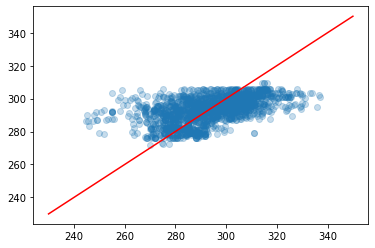

In [10]:
#see whether scaling helps at all
from sklearn import preprocessing

#first a simple linear model (not including species)
x_start = np.array(reduced)
x_model = preprocessing.scale(x_start)
y_model = np.array(Edata.day_mean)
model = LinearRegression().fit(x_model,y_model)
r_sq = model.score(x_model,y_model)
print('coefficient of determination: ', r_sq)
print('intercept: ', model.intercept_)
print('slope: ', model.coef_)
predictions = model.predict(x_model)
plt.scatter(Edata.day_mean,predictions, alpha = 0.25)

x = np.linspace(230,350,100)
plt.plot(x, x, '-r')

coefficient of determination:  0.3419300381655105
intercept:  -92.45700664103634
slope:  [ 0.23256462  1.36520052 -0.42933161  0.39050667 27.85877492]


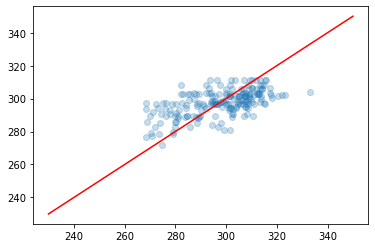

In [11]:
#Go with the unscaled data
#reduce the data to include only locations with more than 20 records
better_sampled = Edata[(Edata.counts >= 20)] 
reduced = better_sampled[['var1','var6', 'var7', 'var8', 'var10']]                
x_model = np.array(reduced)
y_model = np.array(better_sampled.day_mean)
model = LinearRegression().fit(x_model,y_model)
r_sq = model.score(x_model,y_model)
print('coefficient of determination: ', r_sq)
print('intercept: ', model.intercept_)
print('slope: ', model.coef_)
predictions = model.predict(x_model)
plt.scatter(better_sampled.day_mean,predictions, alpha = 0.25)

x = np.linspace(230,350,100)
plt.plot(x, x, '-r')                

(789, 17)
(167, 17)
coefficient of determination:  0.28904232288543363
intercept:  -198.8160364309008
slope:  [ 0.08157242  1.44067606 -0.83726915 -0.17145581 42.98578351]
9.178586049800765


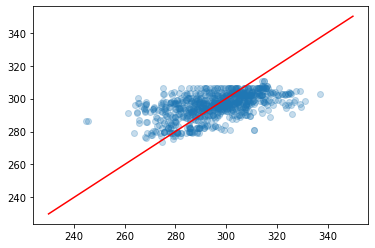

In [12]:
#Go with the unscaled data
#reduce the data to include only locations with more than 5 records
#train with data up to 2018, then test with data from 2019
train = Edata[(Edata.counts >= 5) & (Edata.Year <= 2018)]
test = Edata[(Edata.counts >= 5) & (Edata.Year == 2019)]

print(train.shape)
print(test.shape)

x_train = np.array(train[['var1','var6', 'var7', 'var8', 'var10']]                )
y_train = np.array(train.day_mean)

model = LinearRegression().fit(x_train,y_train)
r_sq = model.score(x_train,y_train)

print('coefficient of determination: ', r_sq)
print('intercept: ', model.intercept_)
print('slope: ', model.coef_)

predictions = model.predict(x_train)
plt.scatter(train.day_mean,predictions, alpha = 0.25)

x = np.linspace(230,350,100)
plt.plot(x, x, '-r')        

differences = abs(train.day_mean - predictions)
print(differences.mean())

11.118873817888725
45.70945563253494


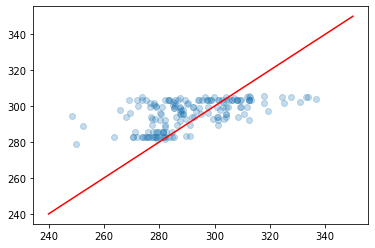

In [13]:
x_test = np.array(test[['var1','var6', 'var7', 'var8', 'var10']])
predictions = model.predict(x_test)

plt.scatter(test.day_mean, predictions, alpha = 0.25)
differences = abs(test.day_mean - predictions)
print(differences.mean())
print(differences.max())
x = np.linspace(240,350,100)
plt.plot(x, x, '-r')


In [14]:
import pickle
pkl_filename = 'means_5obs_linear_model.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

## Try a model with 'Species' included, mixed effects linear model

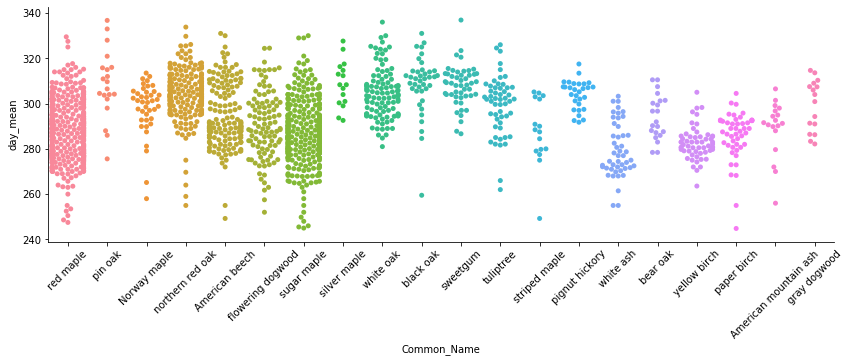

In [15]:
#Look at the differences among the species:
fig = sns.catplot(x = 'Common_Name', y = 'day_mean', data = Edata, kind ='swarm', height = 4, aspect =3)
fig.set_xticklabels(rotation=45)

In [16]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

train = Edata[(Edata.counts >= 5) & (Edata.Year <= 2018)]
test = Edata[(Edata.counts >= 5) & (Edata.Year == 2019)]
print(len(train))
print(len(test))

#print(train['Common_Name'].value_counts())
md = smf.mixedlm("day_mean ~ var1 + var6 + var7 + var8 + var10", train, groups=train['Common_Name'])
mdf = md.fit()
print(mdf.summary())


789
167
          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: day_mean  
No. Observations:  789     Method:             REML      
No. Groups:        20      Scale:              100.6815  
Min. group size:   4       Log-Likelihood:     -2960.9067
Max. group size:   148     Converged:          Yes       
Mean group size:   39.5                                  
---------------------------------------------------------
           Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
---------------------------------------------------------
Intercept -136.909   55.890 -2.450 0.014 -246.452 -27.366
var1         0.043    0.028  1.510 0.131   -0.013   0.098
var6         1.505    0.257  5.859 0.000    1.001   2.008
var7        -0.832    0.330 -2.519 0.012   -1.479  -0.185
var8        -0.018    0.231 -0.077 0.939   -0.470   0.435
var10       37.944    6.137  6.183 0.000   25.916  49.972
Group Var   43.525    1.602                              



11.964091268896832

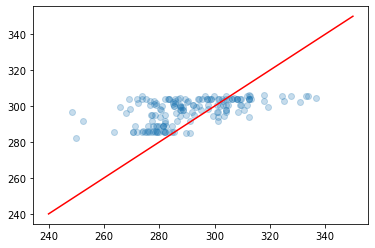

In [17]:
#Evalutate the performance:
residuals = abs(mdf.predict(exog=test)-test.day_mean)

predictions = mdf.predict(exog=test)

#print(results.abs().mean())
plt.scatter(test.day_mean,predictions, alpha = 0.25)
x = np.linspace(240,350,100)
plt.plot(x, x, '-r')

abs(test.day_mean-predictions).mean()
#abs(test.day_mean-predictions).max()
#print(results)

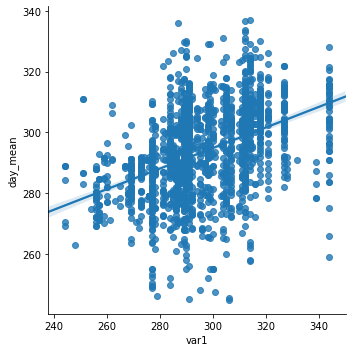

In [18]:
sns.lmplot(x = 'var1', y = 'day_mean', data = Edata)

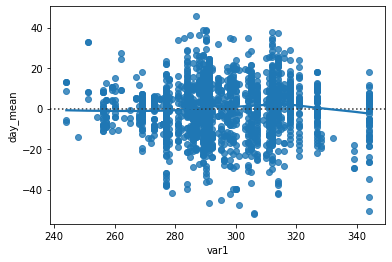

In [19]:
sns.residplot('var1', y = 'day_mean', data = Edata, lowess = True)

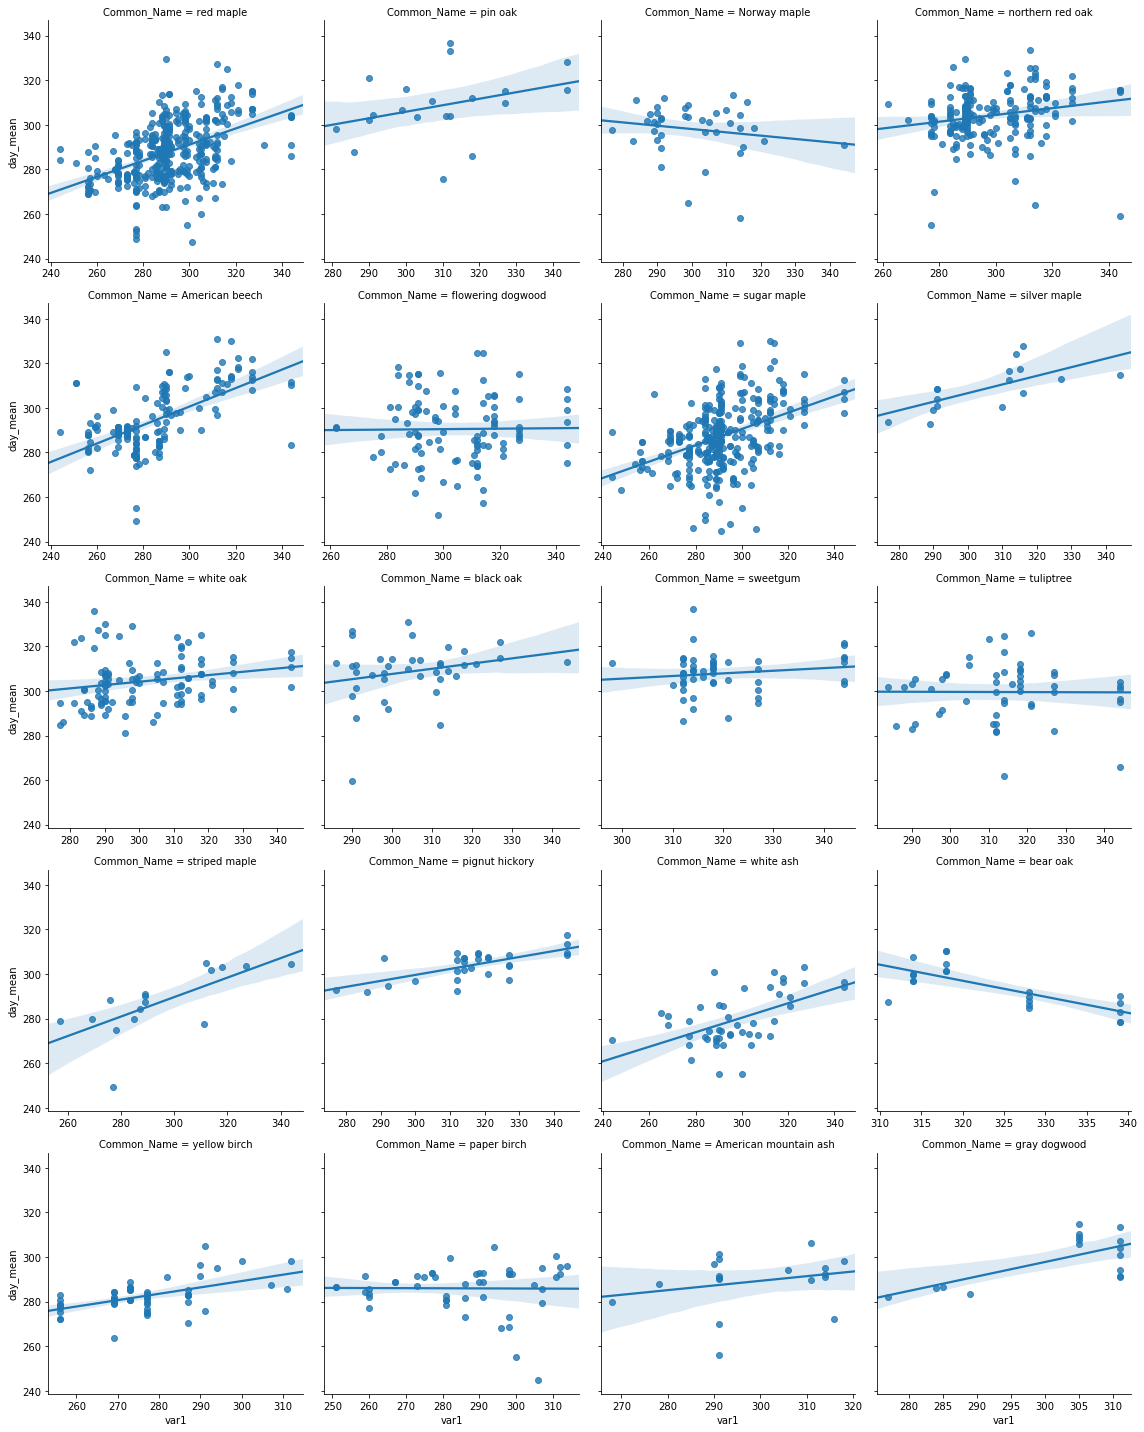

In [20]:
sns.lmplot('var1', y = 'day_mean',col ='Common_Name', sharex=False, col_wrap=4, data = Edata, height = 4)

### Random forest model

In [21]:
#recode data for species 
recodedData = Edata.copy()
s = pd.Series(recodedData.Common_Name)
species_coding = pd.get_dummies(s)
recodedData = pd.concat([recodedData, species_coding], axis=1)
recodedData.head()

,Latitude,Longitude,Year,Common_Name,day_mean,counts,day_std,var1,var2,var3,...,pin oak,red maple,silver maple,striped maple,sugar maple,sweetgum,tuliptree,white ash,white oak,yellow birch
0,39.747726,-77.569374,2014,red maple,302.000000,1,NaN,311.0,319.0,12.926172,...,0,1,0,0,0,0,0,0,0,0
1,39.747726,-77.569374,2015,pin oak,320.928571,14,18.590586,290.0,324.0,15.002828,...,1,0,0,0,0,0,0,0,0,0
2,39.747726,-77.569374,2015,red maple,306.875000,8,13.367738,290.0,324.0,15.002828,...,0,1,0,0,0,0,0,0,0,0
3,39.747726,-77.569374,2019,red maple,289.000000,1,NaN,305.0,313.0,15.299345,...,0,1,0,0,0,0,0,0,0,0
4,39.758430,-77.507004,2015,Norway maple,293.333333,3,5.507571,290.0,312.0,14.061414,...,0,0,0,0,0,0,0,0,0,0


In [22]:
#recodedData.to_csv('recoded_data.csv')
#prune recodedData to only instances that have more than 5 observations (or 20)
reducedData = recodedData[recodedData.counts >= 5]
len(reducedData)

#get data ready for the model:
train = reducedData[reducedData.Year != 2019]
test = reducedData[reducedData.Year == 2019]
train.head()

train_labels = np.array(train['day_mean'])
train_features = np.array(train[['var1','var6', 'var7', 'var8', 'var10', 'American beech',
                     'American mountain ash', 'Norway maple', 'bear oak', 'black oak',
                     'flowering dogwood', 'gray dogwood', 'northern red oak', 'paper birch',
                     'pignut hickory', 'pin oak', 'red maple', 'silver maple','striped maple', 
                     'sugar maple', 'sweetgum', 'tuliptree', 'white ash',
                     'white oak', 'yellow birch']])
test_labels = np.array(test['day_mean'])
test_features = np.array(test[['var1','var6', 'var7', 'var8', 'var10', 'American beech',
                     'American mountain ash', 'Norway maple', 'bear oak', 'black oak',
                     'flowering dogwood', 'gray dogwood', 'northern red oak', 'paper birch',
                     'pignut hickory', 'pin oak', 'red maple', 'silver maple','striped maple', 
                     'sugar maple', 'sweetgum', 'tuliptree', 'white ash',
                     'white oak', 'yellow birch']])
print(train_features.shape)
print(test_features.shape)
print(len(test)/(len(train)+ len(test)))

(789, 25)
(167, 25)
0.17468619246861924


In [47]:
train.Year.unique()

array([2015, 2016, 2017, 2013, 2018, 2014, 2012, 2011])

In [48]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 1000, random_state = 34, bootstrap = True)
rf.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=34, verbose=0, warm_start=False)

In [49]:
predictions_train = rf.predict(train_features)
errors = abs(predictions_train - train_labels)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'days')

predictions = rf.predict(test_features)
errors = abs(predictions - test_labels)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'days')

#calcuate mean absolute precentage error
mape = 100 * (errors/test_labels)
print(mape.mean())

#Calculate accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy,2), '%')

Mean Absolute Error: 2.63 days
Mean Absolute Error: 9.33 days
3.2407969958601495
Accuracy: 96.76 %


In [50]:
#look at feature importances
feature_list = ['var1','var6', 'var7', 'var8', 'var10', 'American beech',
                     'American mountain ash', 'Norway maple', 'bear oak', 'black oak',
                     'flowering dogwood', 'gray dogwood', 'northern red oak', 'paper birch',
                     'pignut hickory', 'pin oak', 'red maple', 'silver maple','striped maple', 
                     'sugar maple', 'sweetgum', 'tuliptree', 'white ash',
                     'white oak', 'yellow birch']

importances = list(rf.feature_importances_)

feature_importances = [(feature, round(importance,2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)


[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: var6                 Importance: 0.25
Variable: var10                Importance: 0.24
Variable: var1                 Importance: 0.12
Variable: var7                 Importance: 0.09
Variable: var8                 Importance: 0.08
Variable: Norway maple         Importance: 0.05
Variable: black oak            Importance: 0.04
Variable: American mountain ash Importance: 0.03
Variable: bear oak             Importance: 0.03
Variable: flowering dogwood    Importance: 0.03
Variable: American beech       Importance: 0.02
Variable: gray dogwood         Importance: 0.02


[None, None, None, None, None, None, None, None, None, None, None, None]

In [51]:
#run the model again with fewer features:
#get data ready for the model:
train = reducedData[reducedData.Year != 2019]
test = reducedData[reducedData.Year == 2019]

train_labels = np.array(train['day_mean'])
train_features = np.array(train[['var1','var6', 'var7', 'var8', 'var10', 'American beech',
                     'flowering dogwood', 'northern red oak','red maple', 'sugar maple',  'white ash',
                     'white oak']])
test_labels = np.array(test['day_mean'])
test_features = np.array(test[['var1','var6', 'var7', 'var8', 'var10', 'American beech',
                     'flowering dogwood', 'northern red oak','red maple', 'sugar maple',  'white ash',
                     'white oak']])
print(train_features.shape)
print(test_features.shape)

(789, 12)
(167, 12)


In [52]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 1000, random_state = 34, bootstrap = True)
rf.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=34, verbose=0, warm_start=False)

In [53]:
#look at feature importances
importances = list(rf.feature_importances_)
feature_list = ['var1','var6', 'var7', 'var8', 'var10', 'American beech',
                     'flowering dogwood', 'northern red oak','red maple', 'sugar maple',  'white ash',
                     'white oak']

feature_importances = [(feature, round(importance,2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)


[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: var6                 Importance: 0.25
Variable: var10                Importance: 0.24
Variable: var1                 Importance: 0.12
Variable: var7                 Importance: 0.09
Variable: var8                 Importance: 0.08
Variable: northern red oak     Importance: 0.05
Variable: sugar maple          Importance: 0.04
Variable: flowering dogwood    Importance: 0.03
Variable: red maple            Importance: 0.03
Variable: white ash            Importance: 0.03
Variable: American beech       Importance: 0.02
Variable: white oak            Importance: 0.02


[None, None, None, None, None, None, None, None, None, None, None, None]

In [54]:
#hyper parameter tuning
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num =10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
max_depth.append(None)
min_samples_split = [2,5, 10]
min_samples_leaf = [1,2,4]
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [55]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_features, train_labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [35]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [44]:
best_random = rf_random.best_estimator_
predictions_train = best_random.predict(train_features)
errors = abs(predictions_train - train_labels)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'days')

predictions = best_random.predict(test_features)
errors = abs(predictions - test_labels)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'days')


Mean Absolute Error: 5.17 days
Mean Absolute Error: 5.42 days


In [39]:
#To get a better estimate of how much error there is, take out each year, refit the model then validate with the held out year

years = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019] 
for year in years:
    train = reducedData[reducedData.Year != year]
    test = reducedData[reducedData.Year == year]
    train_labels = np.array(train['day_mean'])
    train_features = np.array(train[['var1','var6', 'var7', 'var8', 'var10', 'American beech',
                     'flowering dogwood', 'northern red oak','red maple', 'sugar maple',  'white ash',
                     'white oak']])
    test_labels = np.array(test['day_mean'])
    test_features = np.array(test[['var1','var6', 'var7', 'var8', 'var10', 'American beech',
                     'flowering dogwood', 'northern red oak','red maple', 'sugar maple',  'white ash',
                     'white oak']])
    rf_model = RandomForestRegressor(n_estimators = 800, max_depth = 10, min_samples_split = 10, min_samples_leaf= 1 , max_features = 'sqrt', random_state =42, bootstrap = True)
    rf_model.fit(train_features, train_labels)
    predictions_train = rf_model.predict(train_features)
    errors = abs(predictions_train - train_labels)
    print(year)
    print('Mean Absolute Error train:', round(np.mean(errors), 2), 'days')

    predictions = rf_model.predict(test_features)
    errors = abs(predictions - test_labels)
    print('Mean Absolute Error test:', round(np.mean(errors), 2), 'days')


2011
Mean Absolute Error train: 5.33 days
Mean Absolute Error test: 11.21 days
2012
Mean Absolute Error train: 5.34 days
Mean Absolute Error test: 10.0 days
2013
Mean Absolute Error train: 5.32 days
Mean Absolute Error test: 9.55 days
2014
Mean Absolute Error train: 5.38 days
Mean Absolute Error test: 7.76 days
2015
Mean Absolute Error train: 5.44 days
Mean Absolute Error test: 6.78 days
2016
Mean Absolute Error train: 5.34 days
Mean Absolute Error test: 8.18 days
2017
Mean Absolute Error train: 5.27 days
Mean Absolute Error test: 8.74 days
2018
Mean Absolute Error train: 5.48 days
Mean Absolute Error test: 7.34 days
2019
Mean Absolute Error train: 5.2 days
Mean Absolute Error test: 9.16 days


In [57]:
#now fit a model to all of the data (through 2019) that can be used for the app
#do the same type of hyperparameter estimation

full = reducedData
full.head()

full_features = np.array(full[['var1','var6', 'var7', 'var8', 'var10', 'American beech',
                     'flowering dogwood', 'northern red oak','red maple', 'sugar maple',  'white ash',
                     'white oak']])

full_labels = np.array(full['day_mean'])

rf_model = RandomForestRegressor(n_estimators = 800, max_depth = 10, min_samples_split = 10, min_samples_leaf= 1 , max_features = 'sqrt', random_state =42, bootstrap = True)
rf_model.fit(full_features, full_labels)
predictions_full = rf_model.predict(full_features)
errors = abs(predictions_full - full_labels)
print('Mean Absolute Error train:', round(np.mean(errors), 2), 'days')


Mean Absolute Error train: 5.4 days


(array([411., 251., 139.,  81.,  36.,  17.,  14.,   5.,   0.,   2.]),
 array([3.54378007e-03, 3.27686637e+00, 6.55018896e+00, 9.82351155e+00,
        1.30968341e+01, 1.63701567e+01, 1.96434793e+01, 2.29168019e+01,
        2.61901245e+01, 2.94634471e+01, 3.27367697e+01]),
 <a list of 10 Patch objects>)

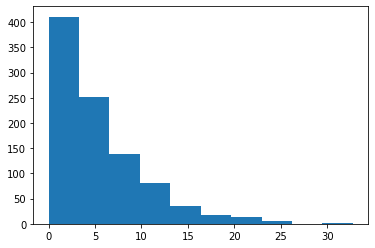

In [58]:
plt.hist(abs(rf_model.predict(full_features)-full_labels))

In [60]:
#look at feature importances
importances = list(rf_model.feature_importances_)
feature_list = ['var1','var6', 'var7', 'var8', 'var10', 'American beech',
                     'flowering dogwood', 'northern red oak','red maple', 'sugar maple',  'white ash',
                     'white oak']

feature_importances = [(feature, round(importance,2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)


[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: var10                Importance: 0.24
Variable: var6                 Importance: 0.19
Variable: var1                 Importance: 0.17
Variable: var7                 Importance: 0.07
Variable: var8                 Importance: 0.06
Variable: northern red oak     Importance: 0.06
Variable: sugar maple          Importance: 0.06
Variable: flowering dogwood    Importance: 0.04
Variable: red maple            Importance: 0.04
Variable: white ash            Importance: 0.03
Variable: American beech       Importance: 0.02
Variable: white oak            Importance: 0.02


[None, None, None, None, None, None, None, None, None, None, None, None]

In [59]:
#save this model for the app
import pickle
pkl_filename = 'rf_2020_model_12_features.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(rf_model, file)


### Compare to a basic model where the only predictor is the day of the previous year

In [61]:
#take the same samples that were used to fix the model
better_sampled = Edata[(Edata.counts >= 5)]
#this data has separate entries for each species in each location/year so take the mean of those to get a single value for each location/year
df_simple = better_sampled.groupby(['Latitude', 'Longitude', 'Year']).day_mean.mean().reset_index(name = 'year_mean')
#keep only the locations that have more than two years 
keepers = df_simple.groupby(['Latitude', 'Longitude']).size().reset_index(name = 'num_of_years')
keepers = keepers[keepers.num_of_years >=2]
compare_years_df = df_simple[(df_simple['Latitude'].isin(keepers.Latitude)) & (df_simple['Longitude'].isin(keepers.Longitude))].reset_index()
compare_years_df.head()

,index,Latitude,Longitude,Year,year_mean
0,7,40.058323,-74.405663,2016,322.400000
1,8,40.058323,-74.405663,2017,304.400000
2,11,40.161480,-77.121925,2016,304.555556
3,12,40.161480,-77.121925,2018,303.000000
4,13,40.178272,-77.116959,2013,313.387500


In [62]:
#make a new column that contains the previous year's foliage date (if it exists)
previous_date = []
for index, row in compare_years_df.iterrows():
    same_location = compare_years_df[(compare_years_df.Latitude == row.Latitude) &(compare_years_df.Longitude == row.Longitude)]
    if any(same_location.Year == row.Year + 1):
        add = float(same_location[same_location.Year == row.Year + 1].year_mean)
        previous_date.append(add)
    else:
        previous_date.append(np.nan)
print(previous_date[0:6])

[304.4, nan, nan, nan, 305.0892857142857, 325.2857142857143]


In [63]:
complete_df = pd.concat([compare_years_df, pd.Series(previous_date, name = 'last_year')], axis = 1)
complete_df

,index,Latitude,Longitude,Year,year_mean,last_year
0,7,40.058323,-74.405663,2016,322.400000,304.400000
1,8,40.058323,-74.405663,2017,304.400000,NaN
2,11,40.161480,-77.121925,2016,304.555556,NaN
3,12,40.161480,-77.121925,2018,303.000000,NaN
4,13,40.178272,-77.116959,2013,313.387500,305.089286
...,...,...,...,...,...,...
379,472,46.231968,-89.542152,2015,270.746988,279.096774
380,473,46.231968,-89.542152,2016,279.096774,268.400000
381,474,46.231968,-89.542152,2017,268.400000,270.381579
382,475,46.231968,-89.542152,2018,270.381579,249.818182


In [64]:
#drop missing values
complete_df = complete_df.dropna()
print(complete_df.shape)
complete_df.head(10)

(227, 6)


,index,Latitude,Longitude,Year,year_mean,last_year
0,7,40.058323,-74.405663,2016,322.400000,304.400000
4,13,40.178272,-77.116959,2013,313.387500,305.089286
5,14,40.178272,-77.116959,2014,305.089286,325.285714
6,15,40.178272,-77.116959,2015,325.285714,297.916667
7,16,40.178272,-77.116959,2016,297.916667,284.600000
10,20,40.412285,-76.924904,2015,301.250000,279.571429
12,23,40.652672,-73.987457,2017,320.194084,311.336540
13,24,40.652672,-73.987457,2018,311.336540,299.787255
15,26,40.655563,-73.997101,2017,325.331515,306.041033
17,28,40.699333,-73.646423,2012,300.333333,327.625000


In [65]:
#calculate the difference between consecutive years in the dataset:
difference = abs(complete_df.last_year - complete_df.year_mean)
complete_df2 = pd.concat([complete_df, pd.Series(difference, name = 'difference')], axis = 1)
sorted_df = complete_df2.sort_values(by = 'difference', ascending = False)
sorted_df.head(10)

,index,Latitude,Longitude,Year,year_mean,last_year,difference
249,318,42.936153,-73.433449,2018,317.363636,282.166667,35.196970
298,381,44.066952,-71.288437,2018,283.460564,252.500000,30.960564
376,467,45.195858,-70.453690,2018,311.000000,280.600000,30.400000
102,125,41.667408,-73.895546,2016,316.571429,286.328379,30.243050
157,193,42.283501,-83.771729,2017,285.818182,314.625000,28.806818
6,15,40.178272,-77.116959,2015,325.285714,297.916667,27.369048
17,28,40.699333,-73.646423,2012,300.333333,327.625000,27.291667
256,327,43.012966,-73.649918,2016,304.555556,278.240741,26.314815
251,322,43.012966,-73.649918,2011,314.333333,289.722222,24.611111
232,287,42.546036,-71.354500,2017,323.200000,299.000000,24.200000


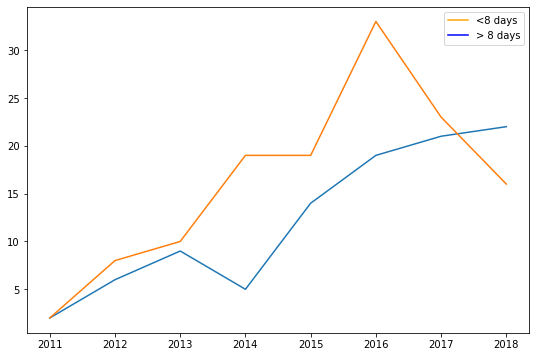

In [66]:
#plot trends over time in how much the date varies between years (more or less than 8 days)
import matplotlib.lines as mlines

wrong = sorted_df[sorted_df['difference']>=8].Year.value_counts().reset_index(name = 'Wrong_more_than_8')
ok = sorted_df[sorted_df['difference']<=8].Year.value_counts().reset_index(name = 'Wrong_less_than_8')

ok.columns = ['Year', 'Wrong_less_than_8']
wrong.columns = ['Year', 'Wrong_more_than_8']

#ok.sort_values('Year').append(wrong)
combined = pd.merge(right = ok.sort_values('Year'), left = wrong.sort_values('Year'))

fig = plt.figure(figsize=(9,6))
plt.plot(combined.Year, combined.Wrong_more_than_8)
plt.plot(combined.Year, combined.Wrong_less_than_8)
line1 = mlines.Line2D([], [], color = 'orange', label = '<8 days')
line2 = mlines.Line2D([], [], color = 'blue', label = '> 8 days')
#line2 = mlines.Line2D([], [], color = 'orange')
plt.legend(handles = [line1,line2])

8.481003650943364

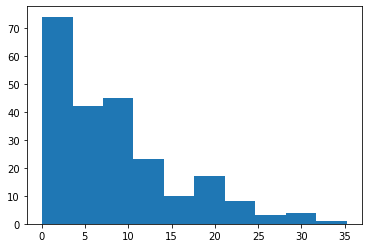

In [67]:
plt.hist(abs(complete_df.last_year - complete_df.year_mean))
abs(complete_df.last_year - complete_df.year_mean).mean()

So how predictive last year's foliage was varies depending on the year. Overall though it's about the same as the model and in some years it's much worse. Climate change might be also making 'last year' less predictive than it used to me. Also there are a lot of l2ocations where there isn't good data and the model will work for anywhere with a similar climate space